<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high. -> People reading the answers woulb be misled 
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.  ---> we want to know why two questions were classified similar bur in real world readers won't ask why it was merged

Why not clustering?

There will be a lot of clusters.

If we want clusters of very similar problems then clusters would be large in no.

Do we need to compare the query pt with each and every pt in the dataset?

Hash Table and invert indices

compare the query pt with those documents which has some or one word same as query pt document -> inverted indices ds

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test and CV Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<p> Given the nature of the problem if a timestamp was given for each question then we could have splitted the dataset based on time stamp. Example-> Suppose we trained the model on data till 6th Jan 2019 and we predict on the upcoming questions after 6th Jan. Now suppose donald trump announced his candidacy for presidency so earlier there might be less questions about him but suddenly the questions about him will increase so we retrain the model and keep it updated </p>

In [114]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
from os import path
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
import plotly.offline as py
from bs4 import BeautifulSoup
from scipy.sparse import csr_matrix
import pickle


from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS
import distance

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.model_selection import GridSearchCV

## 3. Reading and basic Analysis of Data 

In [115]:
df = pd.read_csv("train.csv")

In [116]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [118]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [119]:
len(df[df.is_duplicate == 0])/len(df)

0.630802146973707

In [120]:
len(df[df.is_duplicate == 1])/len(df)

0.369197853026293

In [121]:
### Let's plot a bar plot to see the class labels

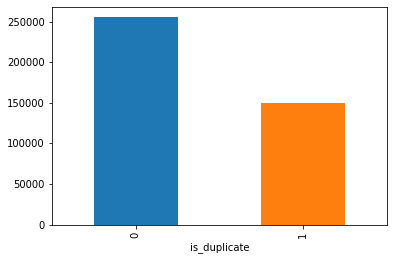

In [122]:
df.groupby('is_duplicate')['id'].count().plot.bar()

#### We see that the data is slightly imbalanced

In [123]:
### Let's check if all the questions are unique

### Every question has it's own unique id so we wil count the unique ids

unids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())

In [124]:
##No of unique questions
len(unids.unique())

537933

In [125]:
##No. of questions appearing more than once
sum(unids.value_counts() > 1)

111780

In [126]:
### Max no. of times a question appeared
max(unids.value_counts())

157

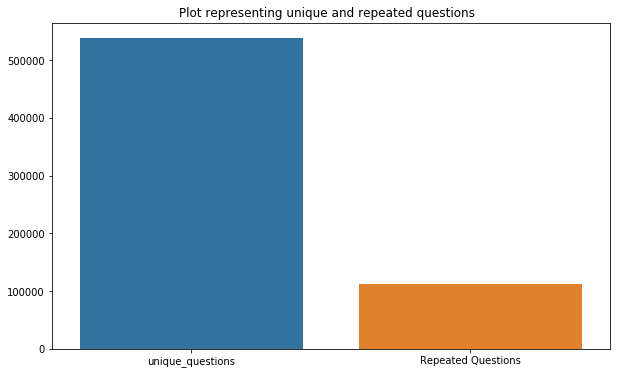

In [127]:
x = ["unique_questions" , "Repeated Questions"]
y =  [len(unids.unique()) , sum(unids.value_counts() > 1)]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [128]:
## Checking if there are duplicate questions or not

duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

In [129]:
print ("Number of duplicate questions",len(duplicates) - len(df))

Number of duplicate questions 0


In [130]:
df.isnull().any()

id              False
qid1            False
qid2            False
question1        True
question2        True
is_duplicate    False
dtype: bool

Maximum number of times a single question is repeated: 157



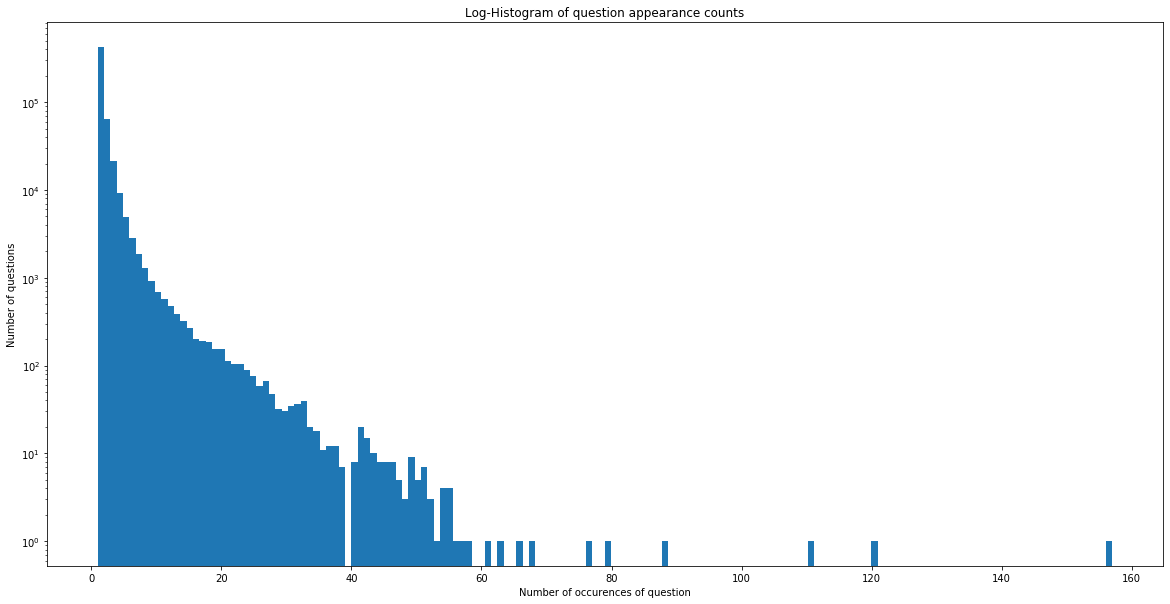

In [131]:
##No. of occurences of each questions

plt.figure(figsize=(20, 10))

plt.hist(unids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(unids.value_counts()))) 

In [132]:
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [133]:
df = df.fillna('')

In [134]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

## 4. Basic Preprocessing

### We will first preprocess our data first and then we will do some basic efature extractions and feature enginnering 

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [135]:
def prepro(x):
    
    soup = BeautifulSoup(x)
    x = soup.get_text()
    
    x = str(x).lower()
    
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    #if type(x) == type(''):
    pattern = re.compile('\W')
    x = re.sub(pattern, ' ', x)
    
    
    #if type(x) == type(''):
    porter = PorterStemmer()
    x = porter.stem(x)
        
    return x

In [136]:
df['question1'] = df['question1'].fillna("").apply(prepro)
df['question2'] = df['question2'].fillna("").apply(prepro)

In [137]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   
2   2     5     6  how can i increase the speed of my internet co...   
3   3     7     8  why am i mentally very lonely  how can i solve...   
4   4     9    10  which one dissolve in water quikly sugar  salt...   

                                           question2  is_duplicate  
0  what is the step by step guide to invest in sh...             0  
1  what would happen if the indian government sto...             0  
2  how can internet speed be increased by hacking...             0  
3  find the remainder when  math 23  24   math  i...             0  
4            which fish would survive in salt water              0

In [138]:
## We are not going to remove stop words as of now and will use it for feature extraction.
## We can of think of it as suppose if a question has a lot of stop words meaning it has less informative keywords and we can really it use it as a feature

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of unique words in Question 1 + Total num of unique words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

But before that we will split our data in Train Test and CV and then feature engineer

In [139]:
y = df['is_duplicate']
X = df.drop(['id','is_duplicate'], axis =1)

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, stratify = y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train,y_train,test_size = 0.3, stratify = y_train)

In [141]:
X_test.shape

(121287, 4)

### 5. Feature Extraction

In [142]:
def word_comm(row):
    w1 = set(map(lambda x: x.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda x: x.lower().strip(), row['question2'].split(" ")))
    
    return len(w1 & w2)


def word_tot(row):
    w1 = set(map(lambda x: x.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda x: x.lower().strip(), row['question2'].split(" ")))
    
    return 1.0*(len(w1) +  len(w2))

In [143]:
def ext_basic_feat(df):
    df['freq_qid1']=df.groupby('qid1')['qid1'].transform('count')  ## transform is used to apply to each data point in each column, here qid1
    df['freq_qid2']=df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda x: len(x.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda x: len(x.split(" ")))


    df['word_Common'] = df.apply(word_comm,axis=1)
    df['word_Total'] = df.apply(word_tot,axis=1)
    
    df['word_share'] = df['word_Common']/df['word_Total']
    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])
    
    return df


In [144]:
X_train = ext_basic_feat(X_train)
X_test = ext_basic_feat(X_test)
X_cv = ext_basic_feat(X_cv)

In [145]:


## Why do we need a function and then why do we need a map function?
## word_share function because -> we have to work with 2 columns so we do df.apply(word_share,axis=1) and in word _share we use the desired columns
## now we have each row and for each sentence we need each word and then we want to lower it an strip so that we can extract common words

EDA on some Extracted Features (Train DATA)

<h3> 5.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [146]:
print ("Minimum length of the questions in question1 : " , min(X_train['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(X_train['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", X_train[X_train['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", X_train[X_train['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 19
Number of Questions with minimum length [question2] : 4


<h4> 5.1.1 Feature: word_share </h4>

Merging y_train with X_train for EDA

In [147]:
X_train.columns

Index(['qid1', 'qid2', 'question1', 'question2', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

In [148]:
X_train['is_duplicate'] = y_train

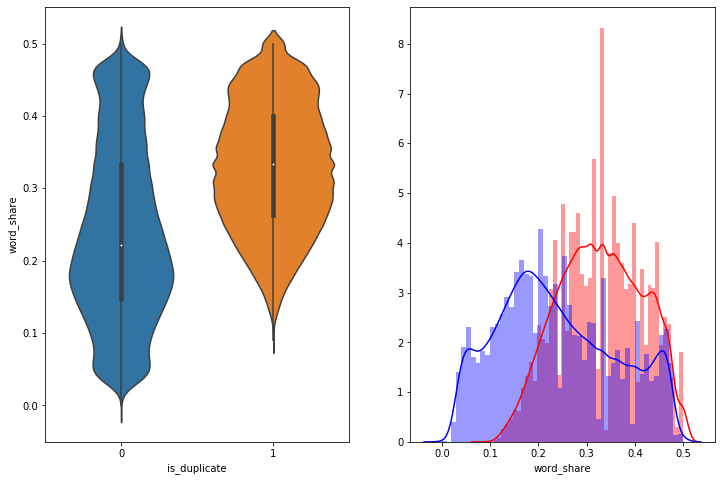

In [149]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = X_train[0:])

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 5.1.2 Feature: word_Common </h4>

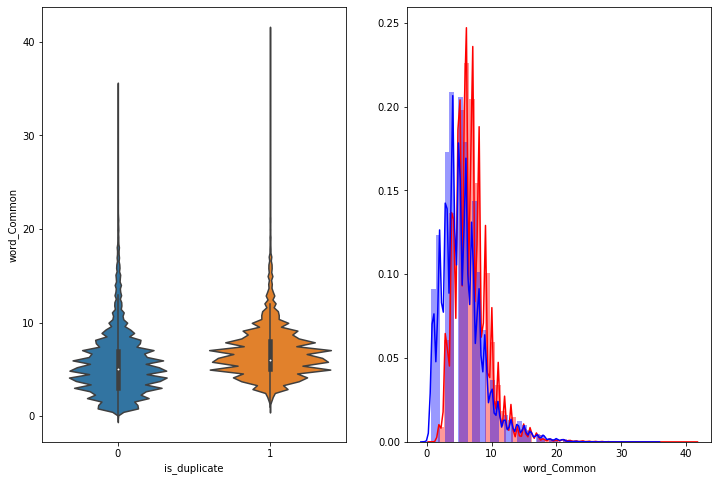

In [150]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = X_train[0:])

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

<h4> 5.1.3 Feature: word_Total </h4>

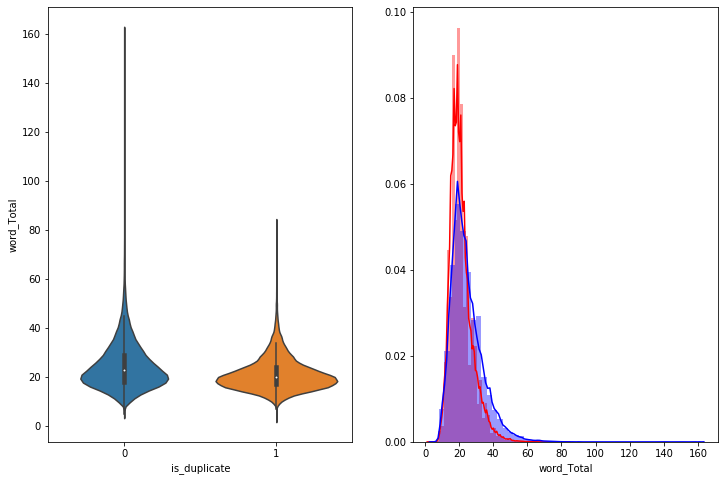

In [151]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Total', data = X_train[0:])

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['word_Total'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['word_Total'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Total in similar and non-similar questions are highly overlapping </p>

<h2> 5.2 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [152]:
X_train.head()

qid1    qid2                                          question1  \
357079  486473  486474                     what is mean by an odd number    
255498  242190  180892  are there people who had successful long dista...   
303212   67754  175714  what are the possible options for india to dea...   
80042   136162  136163  who is the best web marketing companies for ey...   
357854  233501  215545  how can i tell if someone is lying on video chat    

                                                question2  freq_qid1  \
357079                 what do you mean by an odd number           1   
255498  is there a single case of a successful long di...          4   
303212  how can india retaliate against terror sponsor...          5   
80042   where can i practice designing questions in java           1   
357854  how can you tell if someone is lying on the ph...          2   

        freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  \
357079          1     30     34           8           9            7   
255498         12    146     66          23          12            6   
303212          7     71     84          14          14            6   
80042           1     56     49          11           9            1   
357854          2     49     50          12          12            9   

        word_Total  word_share  freq_q1+q2  freq_q1-q2  is_duplicate  
357079        17.0    0.411765           2           0             1  
255498        30.0    0.200000          16           8             1  
303212        28.0    0.214286          12           2             1  
80042         20.0    0.050000           2           0             0  
357854        24.0    0.375000           4           0             1

In [153]:
## For finding or comparing each elements in the two columns
X_train.head(2)[['q1_n_words','q2_n_words']].apply(lambda x: min(x['q1_n_words'], x['q2_n_words']),axis=1) 

357079     8
255498    12
dtype: int64

In [154]:
def get_features(q1, q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    cwc = len(q1_words.intersection(q2_words))
    csc = len(q1_stops.intersection(q2_stops))
    # Get the common Tokens from Question pair
    ctc = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = cwc / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = cwc / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = csc / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = csc / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = ctc / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = ctc / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))   ## tells the longest subdstring
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract(df):
    token_features = df.apply(lambda x: get_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
    
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x['question1'],x['question2']), axis = 1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    
    return df

In [155]:
X_train = extract(X_train)

In [156]:
X_test.shape

(121287, 15)

In [157]:
X_train.columns

Index(['qid1', 'qid2', 'question1', 'question2', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [158]:
X_test = extract(X_test)
X_cv = extract(X_cv)

In [159]:
X_train

qid1    qid2                                          question1  \
357079  486473  486474                     what is mean by an odd number    
255498  242190  180892  are there people who had successful long dista...   
303212   67754  175714  what are the possible options for india to dea...   
80042   136162  136163  who is the best web marketing companies for ey...   
357854  233501  215545  how can i tell if someone is lying on video chat    
214382  319953  319954  are guns in america the ultimate problem  why ...   
401407   30021   46237              what the best way to improve english    
149317  235232  235233     why is  math  pi  math  such a special number    
307209   54188  226692  what are some things new employees should know...   
213310  197751  274666    how do i need to prepare for campus interviews    
26519    49348   49349  how many bollywood actresses are dramebaaz in ...   
231552  193564  262597  how much vinegar do you have to drink to pass ...   
166121  257837  257838              what language did jesus christ speak    
300959  423804  423805  what salary i can expect after having 3 years ...   
68597    64006  118512  what is the real story behind the character sh...   
376928  269502  508136  what is the origin of the family name  talaman...   
130538  205338   84776  how can i fight depression without taking medi...   
283129  403178  403179    what is the unique gift idea for my girlfriend    
342052  469980   67224  could rey be ezra bridger own daughter  does i...   
168828  261411   44255  what are the laws to change your status from a...   
403651   30026    4380  what would be the best programming language to...   
89149   149830  149831  which technology will dominate the next 3 deca...   
347587  246821  476071  is it better to sleep for an hour or not sleep...   
42972    19589   77363  which is a good inpatient drug and alcohol reh...   
194644   10311   26614  how can i increase traffic to my websites by f...   
377061  179497   59999  what are some tips on making it through the jo...   
164248  255263  126557               why is consumer awareness important    
399605  532895  410917  how should i visualize space time in general r...   
54010    95399   95400                 how do i get over feeling unloved    
323975  450009  450010  micro funding  how successful is microfunding ...   
...        ...     ...                                                ...   
332614  297740  459621        which is the best seo company in hyderabad    
188669   74893  287280  what is the best book for philosophy for begin...   
118883  193138  193139  what is the ideal job for a javascript developer    
195249  295636  295637                  was muhammad a military dictator    
285166  405533  405534  how do police officers understand learn about ...   
58841   103156  103157  what are some major landforms in texas  and ho...   
162328  173509   95923                     how do i identify a sociopath    
221369   64481  142328                             how do i beat boredom    
379309  510819  166066  how do i convert an integer into an unsigned i...   
279028   23243  398388  has any country other than india ever had demo...   
220461  327559  327560  where can i find the entire transcript of the ...   
249444  363082  363083  why do american express travelers cheques expire    
402435  535916  535917     why are k l  m shells named so and not a b  c    
68535    68126   14490  what could be the consequences of recalling 50...   
147602  232917  232918                          richest sugar mummy site    
285482  329128  405923            could an atheist become a us president    
109362  179502  179503                                       what is cod    
239730  351377   61560                          what is conditional love    
46597    83330   83331  which subject is best for masters after comple...   
5133     10115   10116                       is dating fun  should it be    
376536

### 5.3 Visualizing the extracted features

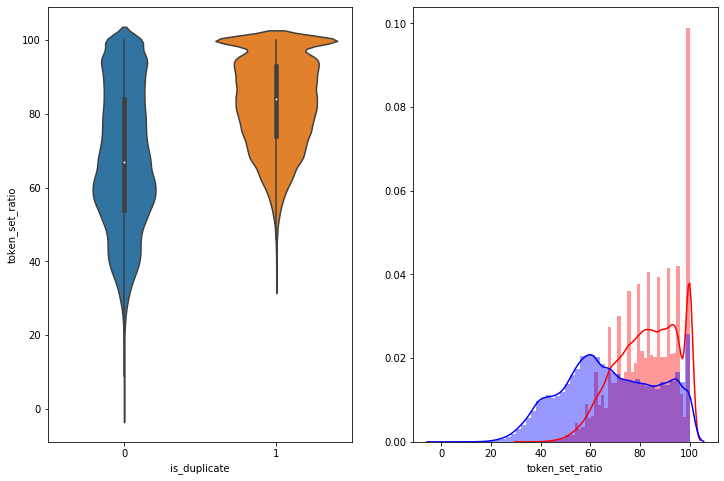

In [160]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_set_ratio', data = X_train[0:])

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['token_set_ratio'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['token_set_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

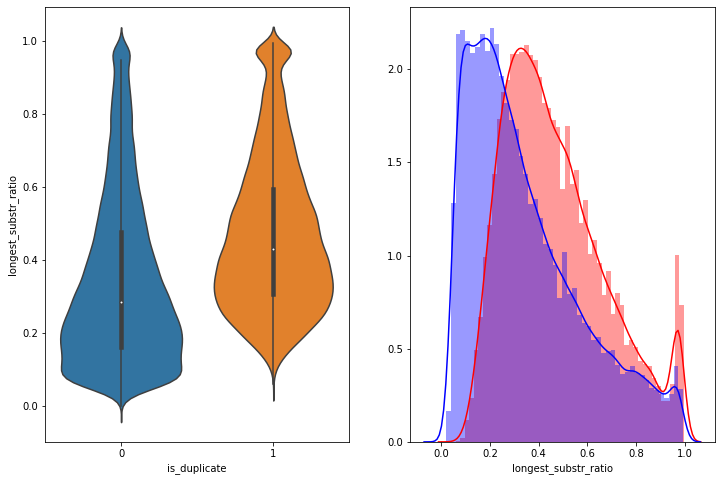

In [161]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'longest_substr_ratio', data = X_train[0:])

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['longest_substr_ratio'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['longest_substr_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

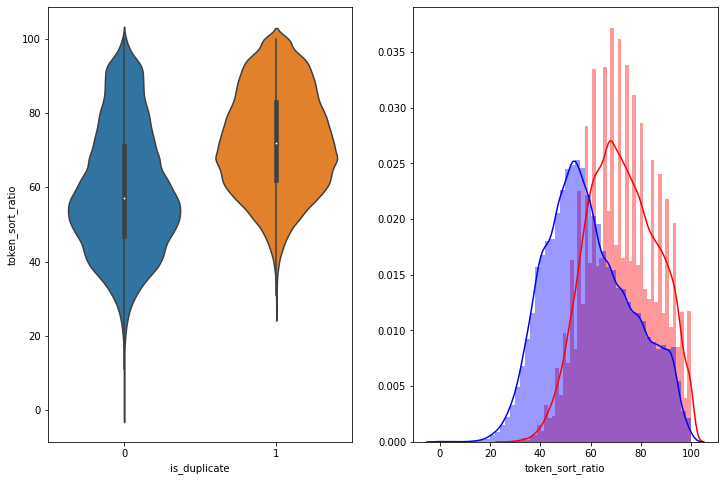

In [162]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = X_train[0:])

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

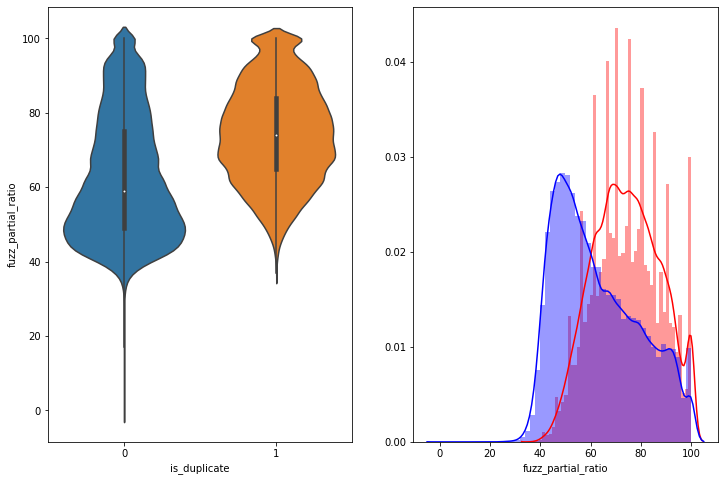

In [163]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_partial_ratio', data = X_train[0:])

plt.subplot(1,2,2)
sns.distplot(X_train[X_train['is_duplicate'] == 1.0]['fuzz_partial_ratio'][0:] , label = "1", color = 'red')
sns.distplot(X_train[X_train['is_duplicate'] == 0.0]['fuzz_partial_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

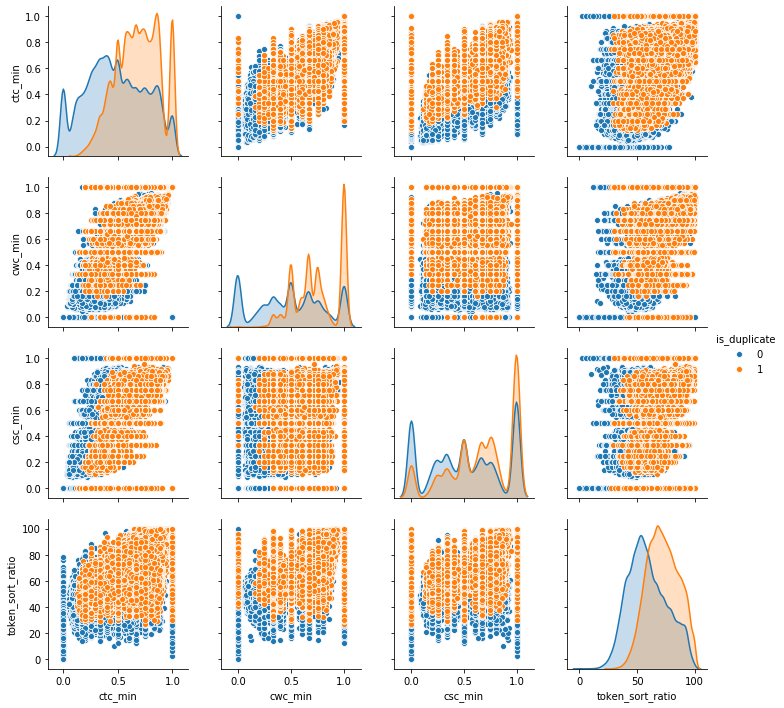

In [164]:

sns.pairplot(X_train[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

So I tried plotting the pair plots between various combinations of plots and 'ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate' seem to be more informative

For cwc_min vs token_sort we can see that there is partial separability and same we can say for ctc_min vs token_sort_ration

In [165]:
df_duplicate = X_train[X_train['is_duplicate'] == 1]
dfp_nonduplicate = X_train[X_train['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s',encoding = 'utf-8')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding = 'utf-8')

Number of data points in class 1 (duplicate pairs) : 146278
Number of data points in class 0 (non duplicate pairs) : 249926


In [166]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt'),encoding="utf-8").read()
textn_w = open(path.join(d, 'train_n.txt'),encoding="utf-8").read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 7892766
Total number of words in non duplicate pair questions : 16270597


In [167]:
type(textp_w)

str

__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


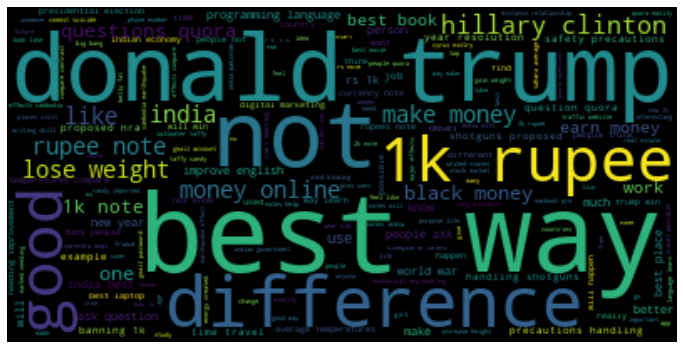

In [168]:
wc = WordCloud(background_color="black", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


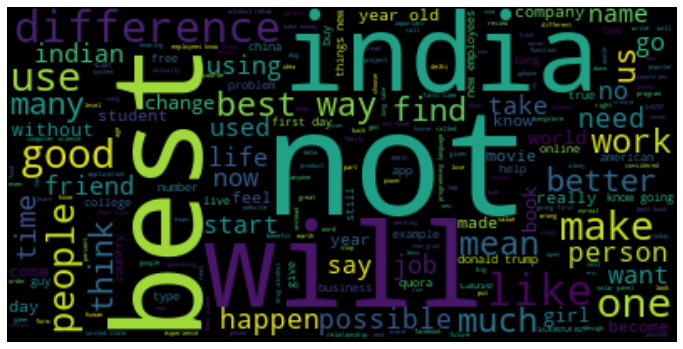

In [169]:
wc = WordCloud(background_color="black", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [170]:
X_train = X_train.drop('is_duplicate',axis =1)

SOme words occur more often in class 1 compared to class 0

### 5.4 Visualizing with TSNE

In [171]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = X_train[0:10000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = y_train[:10000]

In [172]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=2000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.201s...
[t-SNE] Computed neighbors for 10000 samples in 1.065s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.112923
[t-SNE] Computed conditional probabilities in 0.559s
[t-SNE] Iteration 50: error = 95.0378952, gradient norm = 0.0227868 (50 iterations in 6.721s)
[t-SNE] It

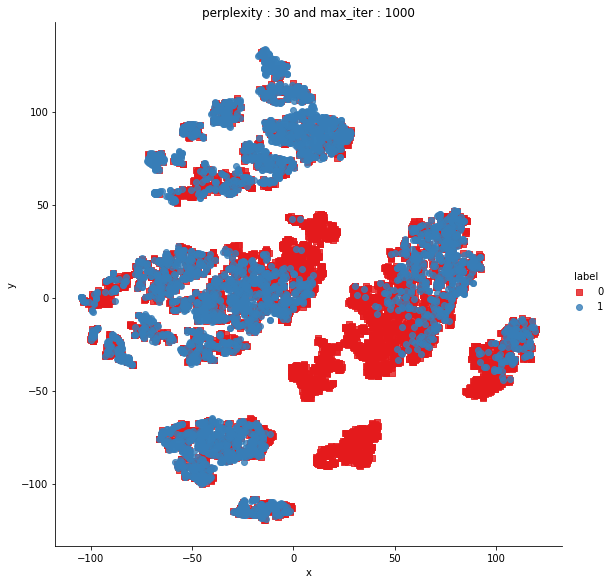

In [173]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [174]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=2000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.038s...
[t-SNE] Computed neighbors for 10000 samples in 1.087s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.112923
[t-SNE] Computed conditional probabilities in 0.518s
[t-SNE] Iteration 50: error = 97.4477386, gradient norm = 0.0075571 (50 iterations in 17.641s)
[t-SNE] I

In [175]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

From the plot we see there are various instances where 0 can be seperated from 1

In [58]:
X_train.columns

Index(['qid1', 'qid2', 'question1', 'question2', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substr_ratio'],
      dtype='object')

## 6. Vectorizing textual features

Now let's vectorize our questions 1 and 2 with simple tfidf values

In [59]:
X_train.shape

(198102, 30)

### 6.1 Vectorizing "question2"

In [60]:
vect = TfidfVectorizer(min_df=10)
vect.fit(X_train['question1'])
train_q1 = vect.transform(X_train['question1'])
cv_q1 = vect.transform(X_cv['question1'])
test_q1 = vect.transform(X_test['question1'])

### 6.2 Vectorizing "question2"

In [61]:
vect2 = TfidfVectorizer(min_df=10)
vect2.fit(X_train['question2'])
train_q2 = vect2.transform(X_train['question2'])
cv_q2 = vect2.transform(X_cv['question2'])
test_q2 = vect2.transform(X_test['question2'])

In [62]:
train_q1.shape


(198102, 10017)

Now as our vectorized values are sparse in nature we will merge them in a scipy sparse matrix

In [63]:
X_train_wq = X_train.drop(['question1', 'question2', 'qid1', 'qid2'],axis=1)
X_cv_wq = X_cv.drop(['question1', 'question2','qid1', 'qid2'],axis=1)
X_test_wq = X_test.drop(['question1', 'question2','qid1', 'qid2'],axis=1)

In [64]:
X_tr = hstack((X_train_wq,train_q1,train_q2)).tocsr()
X_cr = hstack((X_cv_wq,cv_q1,cv_q2)).tocsr()
X_te = hstack((X_test_wq,test_q1,test_q2)).tocsr()

In [65]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 7. Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8899852098181971


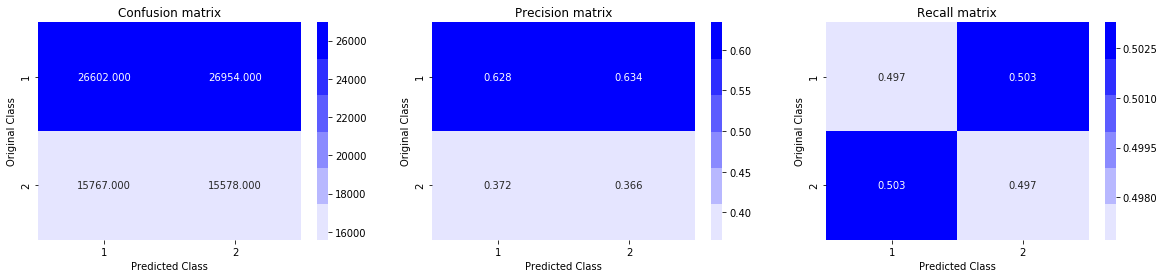

In [95]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((X_cr.shape[0],2))
for i in range(X_cr.shape[0]):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_cv, predicted_y, eps=1e-15))
rand_loss = log_loss(y_cv, predicted_y, eps=1e-15)

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_cv, predicted_y)

Now that our random model has given a log loss of 0.8863197347950676, Our tuned model should have atleast a less log loss than this

We need to make our tp and tn high, we gotta imporve the log loss

<h1> 8. ML Models </h2>

<h2> 8.1 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log train loss is: 0.4801593225446742
For values of alpha =  1e-05 The log cv loss is: 0.5201418905775963
For values of alpha =  0.0001 The log train loss is: 0.49775974796370004
For values of alpha =  0.0001 The log cv loss is: 0.5374953985039331
For values of alpha =  0.001 The log train loss is: 0.47612382791231167
For values of alpha =  0.001 The log cv loss is: 0.5171860985776546
For values of alpha =  0.01 The log train loss is: 0.4850917596559806
For values of alpha =  0.01 The log cv loss is: 0.5249073962992348
For values of alpha =  0.1 The log train loss is: 0.4947718838201976
For values of alpha =  0.1 The log cv loss is: 0.5335299650961581
For values of alpha =  1 The log train loss is: 0.5243221711980173
For values of alpha =  1 The log cv loss is: 0.5552666938210866
For values of alpha =  10 The log train loss is: 0.5676908622425189
For values of alpha =  10 The log cv loss is: 0.5867248353050183


<Figure size 432x432 with 0 Axes>

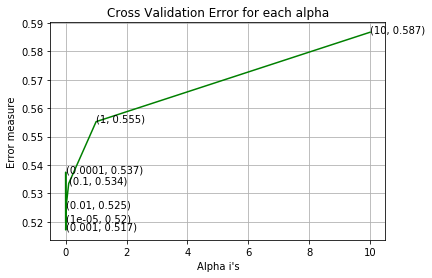

In [77]:
alpha = [10 ** x for x in range(-5, 2)]

log_error_array=[]
log_error_tr_array=[]

for i in alpha:
    
    clf = SGDClassifier(loss='log', penalty ='l2', alpha=i)
    clf.fit(X_tr,y_train)
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(X_tr,y_train)
    predict_y = sig_clf.predict_proba(X_cr)
    predict_y_tr = sig_clf.predict_proba(X_tr)
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    log_error_tr_array.append(log_loss(y_train, predict_y_tr, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log train loss is:",log_loss(y_train, predict_y_tr, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log cv loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

plt.figure(figsize=(6,6))    
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

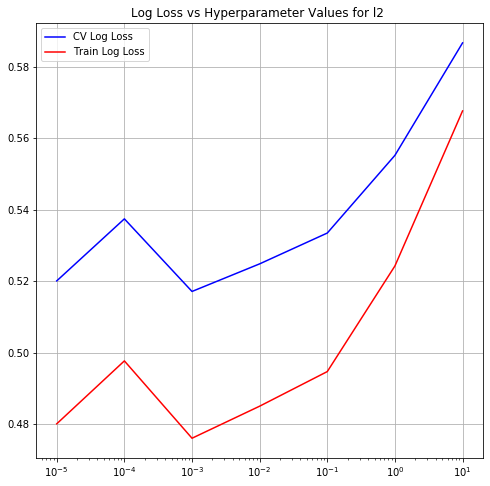

In [78]:
plt.figure(figsize=(8,8))
plt.semilogx(alpha,log_error_array,color='blue',label="CV Log Loss")
plt.semilogx(alpha,log_error_tr_array,color='red',label='Train Log Loss')
plt.title('Log Loss vs Hyperparameter Values for l2 ')
plt.grid()
plt.legend()
plt.show()

For alpha 0.01 we see the least log loss and also the least difference between train and cv log loss, which concludes that our model is not overfitting

Training with 0.01 as alpha

<h2> 8.1.1 Predicting with tuned model </h2>

For values of best alpha =  0.01 The train log loss is: 0.4676149579048492
For values of best alpha =  0.01 The test log loss is: 0.48708025534085864
Total number of data points : 121287


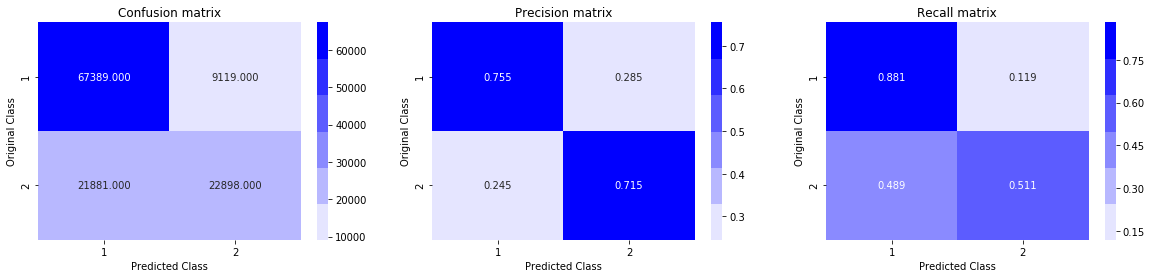

In [73]:
clf = SGDClassifier(alpha=0.01, penalty='l2', loss='log')
clf.fit(X_tr, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr, y_train)

predict_y = sig_clf.predict_proba(X_tr)
print('For values of best alpha = ', 0.01, "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
lr_tr_loss = log_loss(y_train, predict_y,labels=clf.classes_, eps=1e-15)
predict_y = sig_clf.predict_proba(X_te)
print('For values of best alpha = ', 0.01, "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
lr_te_loss = log_loss(y_test, predict_y,labels=clf.classes_, eps=1e-15)
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

Many 2s are classified as 1 and that's what we need to fix

<h2> 8.2 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log train loss is: 0.4814892272332734
For values of alpha =  1e-05 The log cv loss is: 0.5208555764525338
For values of alpha =  0.0001 The log train loss is: 0.4625733134899936
For values of alpha =  0.0001 The log cv loss is: 0.5010163029026459
For values of alpha =  0.001 The log train loss is: 0.4692722934454604
For values of alpha =  0.001 The log cv loss is: 0.5082177615348897
For values of alpha =  0.01 The log train loss is: 0.46482646880096284
For values of alpha =  0.01 The log cv loss is: 0.5032208105857435
For values of alpha =  0.1 The log train loss is: 0.4782106908274076
For values of alpha =  0.1 The log cv loss is: 0.5162597025852114
For values of alpha =  1 The log train loss is: 0.5217611283860208
For values of alpha =  1 The log cv loss is: 0.5502412505057175
For values of alpha =  10 The log train loss is: 0.5534633106334405
For values of alpha =  10 The log cv loss is: 0.5790363634419389


<Figure size 432x432 with 0 Axes>

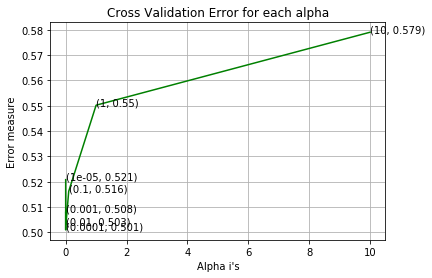

In [80]:
alpha = [10 ** x for x in range(-5, 2)]

log_error_array=[]
log_error_tr_array=[]

for i in alpha:
    
    clf = SGDClassifier(loss='hinge', penalty ='l2', alpha=i)
    clf.fit(X_tr,y_train)
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(X_tr,y_train)
    predict_y = sig_clf.predict_proba(X_cr)
    predict_y_tr = sig_clf.predict_proba(X_tr)
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    log_error_tr_array.append(log_loss(y_train, predict_y_tr, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log train loss is:",log_loss(y_train, predict_y_tr, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log cv loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

plt.figure(figsize=(6,6))    
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

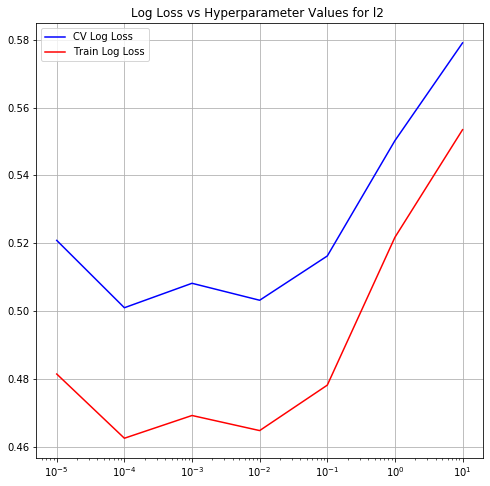

In [81]:
plt.figure(figsize=(8,8))
plt.semilogx(alpha,log_error_array,color='blue',label="CV Log Loss")
plt.semilogx(alpha,log_error_tr_array,color='red',label='Train Log Loss')
plt.title('Log Loss vs Hyperparameter Values for l2 ')
plt.grid()
plt.legend()
plt.show()

For alpha 0.001 we see the least log loss and also the least difference between train and cv log loss, which concludes that our model is not overfitting

Training with 0.001 as alpha

<h2> 8.2.1 Predicting with tuned model </h2>

For values of best alpha =  0.001 The train log loss is: 0.47288677724017325
For values of best alpha =  0.001 The test log loss is: 0.49190457485039396
Total number of data points : 121287


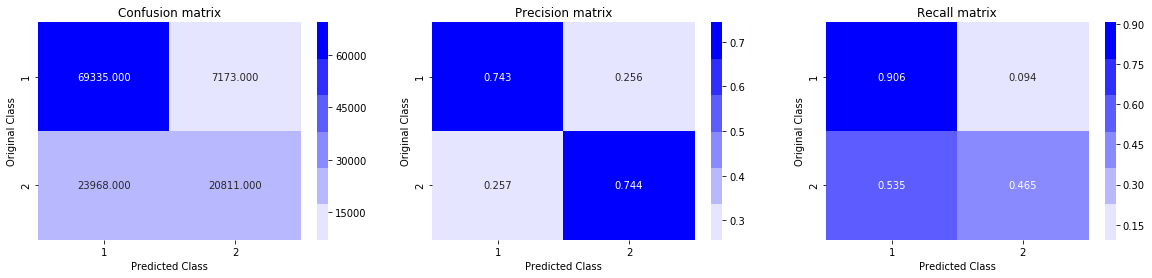

In [74]:
clf = SGDClassifier(alpha=0.001, penalty='l2', loss='hinge')
clf.fit(X_tr, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_tr, y_train)

predict_y = sig_clf.predict_proba(X_tr)
print('For values of best alpha = ', 0.001, "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
svm_tr_loss = log_loss(y_train, predict_y, eps=1e-15)
predict_y = sig_clf.predict_proba(X_te)
print('For values of best alpha = ', 0.001, "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
svm_te_loss = log_loss(y_test, predict_y, eps=1e-15)
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

We see increase in 2,2 but the decrease in 2,1 also not much of a performance increase

<h2> 8.3 XGBoost RandomsearchCV with vectorizer as TF-IDF W2V</h2>

### 8.3.1 Merging Train and CV

As we are using Random Search CV we should Merge the Train and cv dataset for better performance 

In [75]:
X_train.columns

Index(['qid1', 'qid2', 'question1', 'question2', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substr_ratio'],
      dtype='object')

In [76]:
X_train_ap = X_train.append(X_cv)

In [77]:
len(X_train_ap)/(len(X_test) + len(X_train_ap))  ### Sanity Check for train test split

0.7

In [78]:
y_train_ap = y_train.append(y_cv)
X_train_ap = X_train_ap.sample(70000)
y_train_ap = y_train_ap.loc[X_train_ap.index]
X_test_ap = X_test.sample(30000)
y_test_ap = y_test.loc[X_test_ap.index]                 ### Randomly picking 100000 data points  (30k test and 70k train) because Tfidf creares dense matrces and will take a lot of time

In [79]:
X_train_ap.columns

Index(['qid1', 'qid2', 'question1', 'question2', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substr_ratio'],
      dtype='object')

### 8.3.2 Vectorizing question1 and question2 with Tf-Idf W2V vectorization

In [80]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [81]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer(min_df=10)
tfidf_model.fit(X_train_ap['question1'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

### Creating dictionary only for training pts.

 # the avg-w2v for each sentence/review is stored in this list
def tfidf_w2v(preprocessed_essays):
    tfidf_w2v_vectors = []
    for sentence in tqdm(preprocessed_essays): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    
    return tfidf_w2v_vectors

X_train_q1_tfidf_w2v = tfidf_w2v(X_train_ap['question1'])
#X_cv_q1_tfidf_w2v = tfidf_w2v(X_cv['question1'])
X_test_q1_tfidf_w2v = tfidf_w2v(X_test_ap['question1'])

print("After vectorizations")
print(len(X_train_q1_tfidf_w2v), y_train_ap.shape)
#print(len(X_cv_q1_tfidf_w2v), y_cv.shape)
print(len(X_test_q1_tfidf_w2v), y_test_ap.shape)

print("="*100)

100%|██████████| 30000/30000 [00:01<00:00, 16832.56it/s]


After vectorizations
70000 (70000,)
30000 (30000,)


In [82]:
tfidf_model = TfidfVectorizer(min_df=10)
tfidf_model.fit(X_train_ap['question2'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

### Creating dictionary only for training pts.

 # the avg-w2v for each sentence/review is stored in this list
def tfidf_w2v(preprocessed_essays):
    tfidf_w2v_vectors = []
    for sentence in tqdm(preprocessed_essays): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    
    return tfidf_w2v_vectors

X_train_q2_tfidf_w2v = tfidf_w2v(X_train_ap['question2'])
#X_cv_q2_tfidf_w2v = tfidf_w2v(X_cv['question2'])
X_test_q2_tfidf_w2v = tfidf_w2v(X_test_ap['question2'])

print("After vectorizations")
print(len(X_train_q2_tfidf_w2v), y_train_ap.shape)
#print(len(X_cv_q2_tfidf_w2v), y_cv.shape)
print(len(X_test_q2_tfidf_w2v), y_test_ap.shape)

print("="*100)

100%|██████████| 30000/30000 [00:01<00:00, 16034.01it/s]


After vectorizations
70000 (70000,)
30000 (30000,)


In [83]:
X_test_ap.shape

(30000, 30)

In [84]:
X_train_wq = X_train_ap.drop(['question1', 'question2', 'qid1', 'qid2'],axis=1)
#X_cv_wq = X_cv.drop(['question1', 'question2','qid1', 'qid2'],axis=1)
X_test_wq = X_test_ap.drop(['question1', 'question2','qid1', 'qid2'],axis=1)

### 8.3.3 Stacking up the train data and the vectorized questions

In [85]:
X_tr = hstack((X_train_wq,X_train_q1_tfidf_w2v,X_train_q2_tfidf_w2v)).tocsr()
#X_cr = hstack((X_cv_wq,X_cv_q1_tfidf_w2v,X_cv_q2_tfidf_w2v)).tocsr()
X_te = hstack((X_test_wq,X_test_q1_tfidf_w2v,X_test_q2_tfidf_w2v)).tocsr()

In [86]:
X_train_wq.shape

(70000, 26)

In [87]:
X_test_wq.shape

(30000, 26)

### 8.3.4 Tuning the XGBoost Model

In [97]:
from xgboost import XGBClassifier

In [98]:
n_estimators = [100, 300, 500, 700, 900, 1100, 1300, 1500]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
colsample_bytree = [0.1, 0.3, 0.5, 0.7 , 0.9, 1]
subsample = [0.1,0.3,0.5,0.7,0.9,1]

def hyperparameter_tunning(X,Y):
    param_grid = dict(learning_rate=learning_rate,
                      n_estimators=n_estimators,
                      colsample_bytree = colsample_bytree,
                      subsample = subsample)
    
    model = XGBClassifier(nthread=-1)
    kfold = StratifiedKFold(n_splits=3, shuffle=True)
    random_search = RandomizedSearchCV(model, param_grid, scoring="neg_log_loss", cv=kfold, verbose=100)
    random_result = random_search.fit(X,Y)
    
    # Summarize results
    print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
    print()
    means = random_result.cv_results_['mean_test_score']
    stds = random_result.cv_results_['std_test_score']
    params = random_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
        
    return random_result

In [101]:
start = dt.datetime.now()

# Tune hyperparameter values
random_result = hyperparameter_tunning(X_tr,y_train_ap)

print("\nTimeTaken: ",dt.datetime.now() - start)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] subsample=0.1, n_estimators=1300, learning_rate=0.3, colsample_bytree=0.1 
[CV]  subsample=0.1, n_estimators=1300, learning_rate=0.3, colsample_bytree=0.1, score=nan, total= 2.6min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s
[CV] subsample=0.1, n_estimators=1300, learning_rate=0.3, colsample_bytree=0.1 
[CV]  subsample=0.1, n_estimators=1300, learning_rate=0.3, colsample_bytree=0.1, score=nan, total= 2.7min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.6min remaining:    0.0s
[CV] subsample=0.1, n_estimators=1300, learning_rate=0.3, colsample_bytree=0.1 
[CV]  subsample=0.1, n_estimators=1300, learning_rate=0.3, colsample_bytree=0.1, score=nan, total= 2.8min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.5min remaining:    0.0s
[CV] subsample=0.9, n_estimators=1100, learning_rate=0.1, co

In [102]:
random_result.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1100, n_jobs=1,
       nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, verbosity=1)

In [103]:
random_result.best_score_

-0.37343053106047236

In [104]:
random_result.best_params_

{'subsample': 0.9,
 'n_estimators': 1100,
 'learning_rate': 0.1,
 'colsample_bytree': 0.1}

### 8.3.5 Tuning 'max_depth' param

Apart from max_depth we will use these params and tune max_depth, also we know GBDT needs shallow trees so we will check with 2,3,4,5 with above params

In [105]:
with open('t.pickle', 'wb') as f:
    pickle.dump(random_result, f)

Let's tune max_depth

In [106]:
bm = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0,
       learning_rate=0.1, max_delta_step=0,
       min_child_weight=1, missing=None, n_estimators=1300, n_jobs=1,
       nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)
params = {'max_depth' : [2,3,4,5]}
mod = GridSearchCV(param_grid=params,estimator=bm, cv=4, scoring="neg_log_loss", verbose=100)
mod.fit(X_tr,y_train_ap)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=2 .....................................................
[CV] ........... max_depth=2, score=-0.3781524392080755, total=17.9min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 18.0min remaining:    0.0s
[CV] max_depth=2 .....................................................
[CV] ............. max_depth=2, score=-0.37557427426237, total=17.9min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 36.0min remaining:    0.0s
[CV] max_depth=2 .....................................................
[CV] .......... max_depth=2, score=-0.37436148437459765, total=17.7min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 53.9min remaining:    0.0s
[CV] max_depth=2 .....................................................
[CV] .......... max_depth=2, score=-0.38015546045875837, total=17.7min
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1300, n_jobs=1,
       nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 3, 4, 5]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='neg_log_loss',
       verbose=100)

In [107]:
with open('t_grid.pickle', 'wb') as f:
    pickle.dump(mod, f)

In [108]:
mod.best_score_

-0.3672401112735712

In [109]:
mod.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=1300, n_jobs=1,
       nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

### 8.3.7 Training our XGBoost with tuned params

In [88]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4
params['colsample_bytree'] = 0.9
params['n_estimators'] = 1300
params['subsample'] = 0.3
params['learning_rate'] = 0.1
params['nthread'] = -1
params['silent'] = 1

d_train = xgb.DMatrix(X_tr, label=y_train_ap)
d_test = xgb.DMatrix(X_te, label=y_test_ap)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_tr,y_train_ap)
predict_y = bst.predict(d_test)
predict_y_tr = bst.predict(d_train)

[0]	train-logloss:0.657333	valid-logloss:0.657695
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.487157	valid-logloss:0.489095
[20]	train-logloss:0.436444	valid-logloss:0.439714
[30]	train-logloss:0.415993	valid-logloss:0.42026
[40]	train-logloss:0.403476	valid-logloss:0.408811
[50]	train-logloss:0.395561	valid-logloss:0.402953
[60]	train-logloss:0.388677	valid-logloss:0.397854
[70]	train-logloss:0.38334	valid-logloss:0.394719
[80]	train-logloss:0.378213	valid-logloss:0.391844
[90]	train-logloss:0.373398	valid-logloss:0.389011
[100]	train-logloss:0.368867	valid-logloss:0.386392
[110]	train-logloss:0.365259	valid-logloss:0.384803
[120]	train-logloss:0.36132	valid-logloss:0.382955
[130]	train-logloss:0.358215	valid-logloss:0.382048
[140]	train-logloss:0.354682	valid-logloss:0.38024
[150]	train-logloss:0.351895	valid-logloss:0.379467
[160]	train-logloss:0.349184	val

In [89]:
print("The test log loss is:",log_loss(y_test_ap, predict_y, eps=1e-15))
print("The train log loss is:",log_loss(y_train_ap, predict_y_tr, eps=1e-15))

The test log loss is: 0.3709301568433714
The train log loss is: 0.2961752473432921


### 8.3.8 Prediction from XGBoost

Total number of data points : 30000


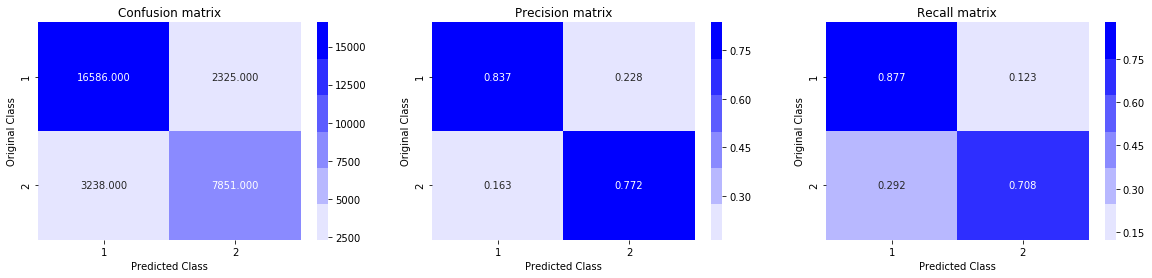

In [90]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_ap, predicted_y)

In [91]:
xg_te_loss = log_loss(y_test_ap, predict_y, eps=1e-15)
xg_tr_loss = log_loss(y_train_ap, predict_y_tr, eps=1e-15)

### 9. Conclusion and Summary of the models

In [97]:
from prettytable import PrettyTable
pt = PrettyTable(["Model","Vectorization Type", "Train Loss", "Test Loss"])
pt.add_row(["Random Model","----", rand_loss, rand_loss])
pt.add_row(["Log Reg","Tf-Idf", lr_tr_loss, lr_te_loss])
pt.add_row(["Linear SVM","Tf-Idf", svm_tr_loss, svm_te_loss])
pt.add_row(["XGBoost","Tf-Idf W2V", xg_tr_loss, xg_te_loss])
print(pt)

+--------------+--------------------+---------------------+---------------------+
|    Model     | Vectorization Type |      Train Loss     |      Test Loss      |
+--------------+--------------------+---------------------+---------------------+
| Random Model |        ----        |  0.8899852098181971 |  0.8899852098181971 |
|   Log Reg    |       Tf-Idf       |  0.4676149579048492 | 0.48708025534085864 |
|  Linear SVM  |       Tf-Idf       | 0.47288677724017325 | 0.49190457485039396 |
|   XGBoost    |     Tf-Idf W2V     |  0.2961752473432921 |  0.3709301568433714 |
+--------------+--------------------+---------------------+---------------------+
